In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.graph_objs as go

## Funcion Objetivo

In [2]:
def funcion_objetivo(x):
    # Assuming `x` is a numpy array with two elements, x[0] and x[1]
    sum1 = sum(i * np.cos((i + 1) * x[0] + i) for i in range(1, 6))
    sum2 = sum(i * np.cos((i + 1) * x[1] + i) for i in range(1, 6))
    return sum1 * sum2

## Inicializar Poblacion

In [3]:
def inicializar_poblacion(pop_size, bounds, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    population = []
    for _ in range(pop_size):
        individual = np.round(np.random.uniform(bounds[0], bounds[1], size=2), 4)  # Two genes for x1 and x2
        population.append(individual)
    return np.array(population)

## Evaluar Poblacion

In [26]:
def evaluacion_aptitud(poblacion, columna=None):
    # Si se pasa una columna de DataFrame, extraer esa columna como lista
    if columna is not None:
        poblacion = poblacion[columna].tolist()
        
    n = len(poblacion)
    aptitud = []
    matriz_con_aptitud = pd.DataFrame()
    
    # Calcular la aptitud para cada individuo
    for individuo in poblacion:
        aptitud.append(funcion_objetivo(individuo))  # Evaluamos la aptitud usando la función objetivo
    
    # Guardar en el DataFrame los individuos y sus aptitudes
    matriz_con_aptitud["POBLACION"] = [list(ind) for ind in poblacion]  # Guardamos cada individuo
    matriz_con_aptitud["APTITUD"] = aptitud  # Aptitud de cada individuo
    
    # Redondear la columna de aptitud a 4 decimales
    matriz_con_aptitud["APTITUD"] = matriz_con_aptitud["APTITUD"].round(4)
    
    return matriz_con_aptitud


## Ordenar

In [5]:
def ordenar(df, columna, ascending=True):

    df_ordenado = df.sort_values(by=columna, ascending=ascending).reset_index(drop=True)
    return df_ordenado

## Metodos de Seleccion

## Ranking

In [6]:
def rank_seleccion(poblacion):
    valores_geneticos = poblacion["POBLACION"].values  # Extrae solo la columna de valores genéticos
    n = len(valores_geneticos)
    poblacion_hijos = []
    i = 0
    
    # Generamos hijos mediante cruce de pares adyacentes en la población ordenada
    while i < n - 1:
        padre1 = valores_geneticos[i]
        padre2 = valores_geneticos[i + 1]
        
        # Realizamos cruce (un punto o homogéneo)
        hijo_1, hijo_2 = cruza_un_corte(padre1, padre2)  # Puedes cambiar a cruza_homogenea si lo prefieres
        
        # Agregamos solo los hijos sin valores de aptitud
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
        
        i += 2  # Avanzamos de dos en dos para el cruce de pares
    
    return poblacion_hijos

## Torneo

In [7]:
def tournament(poblacion):
    n = len(poblacion)  # Número de individuos en la población
    poblacion_hijos = []

    for i in range(n // 2):
        # Tomamos padres en pares desde la columna "POBLACION"
        padre1 = poblacion["POBLACION"].iloc[i]
        padre2 = poblacion["POBLACION"].iloc[n - 1 - i]
        
        # Aplicamos cruce homogéneo (puedes descomentar para probar)
        # hijo_1, hijo_2 = cruza_homogenea(padre1, padre2)
        hijo_1, hijo_2 = cruza_un_corte(padre1, padre2)
        
        # Añadimos los hijos generados a la nueva población de hijos
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
    
    return poblacion_hijos

## Aleatorio Monogamico

In [8]:
def aleatorio_monogamico(poblacion):
    n = len(poblacion)  # Número de individuos en la población
    # Creamos una lista de individuos únicamente a partir de la columna "POBLACION"
    poblacion_disponible = poblacion["POBLACION"].tolist()  # Lista de individuos para la selección aleatoria
    poblacion_hijos = []
    
    # Generamos n/2 pares de padres para obtener una nueva población de hijos
    while len(poblacion_hijos) < n:
        # Selección aleatoria de una pareja de padres
        pareja = random.sample(poblacion_disponible, 2)
        
        # Aplicamos cruce homogéneo entre los padres seleccionados
        hijo_1, hijo_2 = cruza_un_corte(np.array(pareja[0]), np.array(pareja[1]))
        
        # Añadimos los hijos generados a la nueva población de hijos
        poblacion_hijos.append(hijo_1)
        poblacion_hijos.append(hijo_2)
        
        # Eliminamos los padres seleccionados de la población disponible para evitar repetición
        poblacion_disponible.remove(pareja[0])
        poblacion_disponible.remove(pareja[1])
    
    return poblacion_hijos[:n]  # Retornamos exactamente n hijos

## Cruza por un corte

In [9]:
def cruza_un_corte(padre1, padre2):
    num_genes = len(padre1)
    punto_corte = num_genes // 2  # Definimos el punto de corte en la mitad

    # Creamos los hijos usando el cruce en el punto definido
    hijo_1 = np.concatenate((padre1[:punto_corte], padre2[punto_corte:]))
    hijo_2 = np.concatenate((padre2[:punto_corte], padre1[punto_corte:]))
    
    return hijo_1, hijo_2

## Mutacion

In [10]:
def operador_mutacion(poblacion, tasa_mutacion=0.5, rango_mutacion=0.5, decimales=4):
    # Ordenar la población por aptitud en orden ascendente (suponiendo que valores menores son peores)
    #poblacion = poblacion.sort_values(by="APTITUD", ascending=True).reset_index(drop=True)
    
    # Determinar el 10% de la población (peor 10%) para la mutación
    num_mutar = max(1, int(len(poblacion) * 0.2))  # Asegura que al menos un individuo sufra mutación
    indices_a_mutar = poblacion.index[-num_mutar:]  # Selecciona los índices del peor 10%
    
    # Aplicar mutación
    for idx in indices_a_mutar:
        individuo = poblacion.at[idx, "POBLACION"]
        
        # Aplicar mutación a cada gen del individuo y redondear a los decimales deseados
        mutado = [np.round(gen + np.random.uniform(-rango_mutacion, rango_mutacion) 
                           if np.random.rand() < tasa_mutacion else gen, decimales) 
                  for gen in individuo]
        
        # Actualizar el individuo mutado en la población
        poblacion.at[idx, "POBLACION"] = mutado
    
    return poblacion

## Algoritmo Genetico

In [22]:
def run_GA(poblacion, num_generaciones,pop_size ):

    print("Comienza el Algoritmo Genetico")

    if not isinstance(poblacion, pd.DataFrame):
        poblacion = pd.DataFrame({"POBLACION": [list(ind) for ind in poblacion]})
    
    #Variables para guardar el historico de cada generacion
    mean_fitness_history = []
    best_fitness_history = []
    snapshots = {}
    
    
    for generacion in range(num_generaciones):
        #Guardar valores para comparar entre la primera, mitad y ultima generacion
        if generacion == 0:
            snapshots["first"] = poblacion.copy()
        elif generacion == num_generaciones // 2:
            snapshots["middle"] = poblacion.copy()
        elif generacion == num_generaciones - 1:
            snapshots["last"] = poblacion.copy()
    
        print(f'Generacion {generacion}')
        #Evaluar a los pobladores
        poblacionInicialEvaluada = evaluacion_aptitud(poblacion, 'POBLACION')
        poblacionOrdenada = ordenar(poblacionInicialEvaluada, columna='APTITUD')

        #Obtener la media y la mejor aptitud
        mean_fitness = np.mean(poblacionOrdenada['APTITUD'])
        best_fitness = np.max(poblacionOrdenada['APTITUD'])  # Max because we're using negative values for minimization
        
        #Guardar la media y mejor aptitud
        mean_fitness_history.append(mean_fitness)
        best_fitness_history.append(best_fitness)

        #Cruza De Hijos Seleccion Torneo
        hijos = rank_seleccion(poblacionOrdenada)
        evaluacionHijos = evaluacion_aptitud(hijos)

        unionPadresHijos = pd.concat([poblacionOrdenada, evaluacionHijos], ignore_index=True)
        poblacionOrdenada = ordenar(unionPadresHijos, columna='APTITUD')

        poblacionMutada = operador_mutacion(poblacionOrdenada)
        poblacionEvaluada = evaluacion_aptitud(poblacionMutada,'POBLACION')
        poblacionFinal = ordenar(poblacionEvaluada, columna='APTITUD')

        poblacion = poblacionFinal[0:pop_size]

    mejor_solucion = poblacion.loc[poblacion_evaluada["APTITUD"].idxmax(), "POBLACION"]
    mejor_aptitud_final = poblacion["APTITUD"].max()

    return {
        "final_population": poblacion,
        "mejor_solucion": mejor_solucion,
        "best_solution_fitness": mejor_aptitud_final,
        "mean_fitness_history": mean_fitness_history,
        "best_fitness_history": best_fitness_history,
        "snapshots": snapshots
    }

In [87]:
num_generaciones = 10
pop_size = 250
limites = [-10, 10]

poblacion1 = inicializar_poblacion(pop_size, limites, random_state=0)
resultado = run_GA(poblacion1, num_generaciones, pop_size)

Comienza el Algoritmo Genetico
Generacion 0
Generacion 1
Generacion 2
Generacion 3
Generacion 4
Generacion 5
Generacion 6
Generacion 7
Generacion 8
Generacion 9


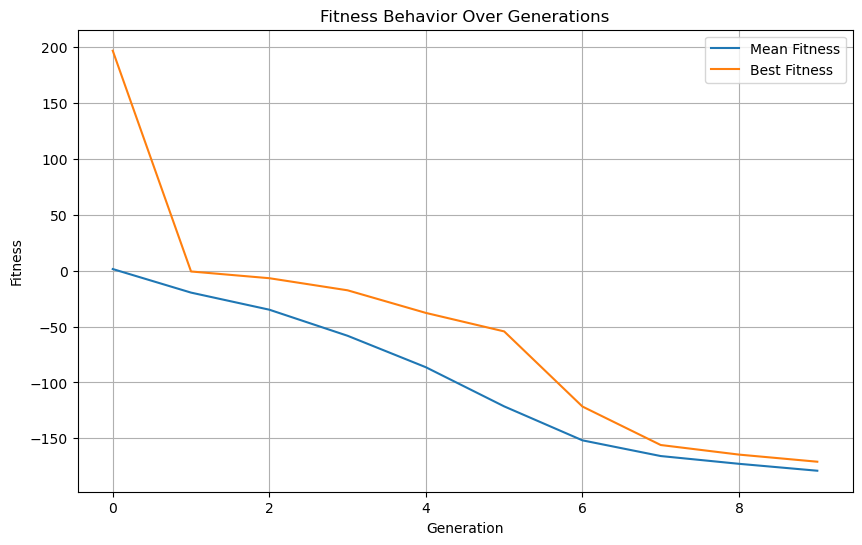

Mejor Aptitud: -178.5519
Mejor Solucion [-0.8029, -1.4246]
              POBLACION   APTITUD
0    [-0.8029, -1.4246] -186.7156
1     [-1.4389, 5.4809] -186.2824
2     [-1.4389, 5.4809] -186.2824
3     [-1.4389, 5.4809] -186.2824
4     [-1.4389, 5.4809] -186.2824
..                  ...       ...
245  [-0.8029, -7.6494] -178.5519
246  [-0.8029, -7.6494] -178.5519
247  [-0.8029, -7.6494] -178.5519
248  [-0.8029, -7.6494] -178.5519
249  [-0.8029, -7.6494] -178.5519

[250 rows x 2 columns]


In [89]:
plt.figure(figsize=(10, 6))
plt.plot(resultado["mean_fitness_history"], label="Mean Fitness")
plt.plot(resultado["best_fitness_history"], label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Behavior Over Generations")
plt.legend()
plt.grid()
plt.show()

print("Mejor Aptitud:",resultado["best_solution_fitness"])
print("Mejor Solucion",resultado["mejor_solucion"])
print(resultado['final_population'])

In [25]:
sum1 = sum(i * np.cos((i + 1) * x[0] + i) for i in range(1, 6))
sum2 = sum(i * np.cos((i + 1) * x[1] + i) for i in range(1, 6))
print(sum1 * sum2)


IndentationError: unexpected indent (2168656285.py, line 2)

In [36]:
x = np.linspace(limites[0], limites[1], 500)
y = np.linspace(limites[0], limites[1], 500)
X, Y = np.meshgrid(x, y)
Z = funcion_objetivo(np.array([X, Y]))

# Define a function to create a plot for a specific generation
def plot_generation(generation_name, color):
    fig = go.Figure()

    # Add the surface plot
    fig.add_trace(go.Surface(z=Z, x=X, y=Y, colorscale="Viridis", opacity=0.5))

    # Plot the population points for the given generation
    population_snapshot = resultado["snapshots"][generation_name]
    fig.add_trace(go.Scatter3d(
        x=population_snapshot[:, 0],
        y=population_snapshot[:, 1],
        z=funcion_objetivo(population_snapshot.T),
        mode='markers',
        marker=dict(size=5, color=color, opacity=0.8),
        name=f"{generation_name.capitalize()} Generation"
    ))

    # Set titles and labels
    fig.update_layout(
        title=f"Interactive 3D Plot - {generation_name.capitalize()} Generation",
        scene=dict(
            xaxis_title="x1",
            yaxis_title="x2",
            zaxis_title="Objective Value"
        ),
        width=800,
        height=600
    )

    fig.show()

# Plot for each generation separately
plot_generation("first", "red")     # First generation in red
plot_generation("middle", "red")    # Middle generation in blue
plot_generation("last", "red")     # Last generation in green

InvalidIndexError: (slice(None, None, None), 0)